In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data=pd.read_csv("/content/drive/MyDrive/combined_data_1.txt",header=None,usecols=[0,1],names=["cust_id","rating"])

In [6]:
data.head()

,cust_id,rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24058263 entries, 0 to 24058262
Data columns (total 2 columns):
 #   Column   Dtype  
---  ------   -----  
 0   cust_id  object 
 1   rating   float64
dtypes: float64(1), object(1)
memory usage: 367.1+ MB


In [8]:
data["rating"] = data["rating"].astype(float)

In [9]:
grp = data.groupby("rating")["rating"].agg(["count"])

In [10]:
grp

,count
rating,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


In [11]:
movie_id_count = data.isnull().sum()[1]

In [12]:
movie_id_count

4499

In [13]:
cust_count = data["cust_id"].nunique() - movie_id_count

In [14]:
cust_count

470758

In [15]:
rating_count = data["cust_id"].count() - movie_id_count

In [16]:
rating_count

24053764

Text(0.5, 1.0, 'Sumary: 4499 Movies , 470758 Customers, 24053764 ratings given')

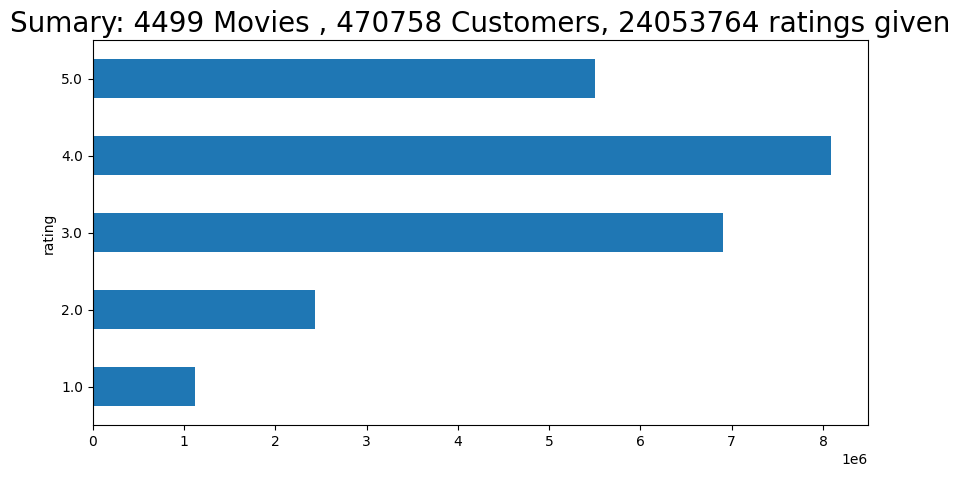

In [17]:
plt = grp.plot(kind ='barh',legend=False,figsize=(10,5))
plt.set_title(f'Sumary: {movie_id_count} Movies , {cust_count} Customers, {rating_count} ratings given', fontsize =20)

In [18]:
df_nan = pd.DataFrame(pd.isnull(data.rating))

In [19]:
df_nan

,rating
0,True
1,False
2,False
3,False
4,False
...,...
24058258,False
24058259,False
24058260,False
24058261,False


In [20]:
df_nan = df_nan[df_nan['rating'] == True]

In [21]:
df_nan

,rating
0,True
548,True
694,True
2707,True
2850,True
...,...
24046714,True
24047329,True
24056849,True
24057564,True


In [22]:
df_nan.shape

(4499, 1)

In [23]:
df_nan=df_nan.reset_index()

In [24]:
df_nan

,index,rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True
...,...,...
4494,24046714,True
4495,24047329,True
4496,24056849,True
4497,24057564,True


In [25]:
movie_np=[]
movie_id=1
for i,j in zip(df_nan["index"][1:],df_nan["index"][:-1]):
  temp = np.full((1,i-j-1),movie_id)
  movie_np = np.append(movie_np,temp)
  movie_id +=1
last_record = np.full((1,len(data) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)


In [26]:
movie_np

array([1.000e+00, 1.000e+00, 1.000e+00, ..., 4.499e+03, 4.499e+03,
       4.499e+03])

In [27]:
data = data[pd.notnull(data['rating'])]
data['movie_id'] = movie_np.astype(int)
data['cust_id'] =data['cust_id'].astype(int)

In [28]:
data

,cust_id,rating,movie_id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
24058258,2591364,2.0,4499
24058259,1791000,2.0,4499
24058260,512536,5.0,4499
24058261,988963,3.0,4499


In [30]:
data

,cust_id,rating,movie_id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
24058258,2591364,2.0,4499
24058259,1791000,2.0,4499
24058260,512536,5.0,4499
24058261,988963,3.0,4499


In [31]:
data_summary = data.groupby("movie_id")["rating"].agg(["count"])

In [32]:
data_summary

,count
movie_id,
1,547
2,145
3,2012
4,142
5,1140
...,...
4495,614
4496,9519
4497,714


In [33]:
round(data_summary["count"].quantile(0.6),0)

908.0

In [34]:
benchmark1 = round(data_summary["count"].quantile(0.6),0)
drop_movies= data_summary[data_summary["count"]<benchmark1].index

In [35]:
cust_summary = data.groupby("cust_id")["rating"].agg(["count"])

In [36]:
round(cust_summary["count"].quantile(0.6),0)

36.0

In [37]:
benchmark2 = round(cust_summary["count"].quantile(0.6),0)

In [38]:
drop_cust=cust_summary[cust_summary["count"]<benchmark2].index

In [39]:
data = data[~data["movie_id"].isin(drop_movies)]
data = data[~data["cust_id"].isin(drop_cust)]

In [40]:
movie_title = pd.read_csv("movie_titles.csv",encoding="ISO-8859-1",header=None,usecols=[0,1,2],names=["movie_id","year","name"])

In [41]:
movie_title.set_index("movie_id",inplace=True)

In [42]:
! pip install scikit-surprise

In [43]:
from surprise import Reader,Dataset,SVD

In [44]:
from surprise.model_selection import cross_validate

In [45]:
reader=Reader()

In [46]:
model = SVD()

In [47]:
df= Dataset.load_from_df(data[["cust_id","movie_id","rating"]][:100000],reader)

In [48]:
cross_validate(model,df,measures=['RMSE','MAE'],cv=4,verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 4 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Mean    Std     
RMSE (testset)    1.0179  1.0186  1.0149  1.0206  1.0180  0.0021  
MAE (testset)     0.8103  0.8068  0.8068  0.8223  0.8115  0.0064  
Fit time          2.53    2.32    2.10    3.31    2.56    0.46    
Test time         0.22    0.13    0.45    0.29    0.27    0.12    


{'test_rmse': array([1.0178621 , 1.01862139, 1.01488455, 1.02062782]),
 'test_mae': array([0.81028571, 0.80678051, 0.80677008, 0.82233997]),
 'fit_time': (2.526819944381714,
  2.3165879249572754,
  2.1004927158355713,
  3.3122665882110596),
 'test_time': (0.21982359886169434,
  0.12657856941223145,
  0.4521634578704834,
  0.2931537628173828)}

To find all the movies rated as 5 stars by user with userId = 712664


In [49]:
data_712664 = data[(data["cust_id"]==712664) & (data["rating"]==5)]

In [50]:
data_712664 = data_712664.set_index("movie_id")

In [51]:
data_712664 = data_712664.join(movie_title)['name']

In [52]:
data_712664.head(10)

movie_id
3                              Character
79                           The Killing
175                       Reservoir Dogs
199                      The Deer Hunter
241                   North by Northwest
256    Ghost Dog: The Way of the Samurai
348        The Last Temptation of Christ
357                House of Sand and Fog
416                             Elephant
442                  Mississippi Burning
Name: name, dtype: object

Train an SVD to predict ratings for user with userId = 1

In [53]:
user_712664 = movie_title.copy()

In [54]:
user_712664 = user_712664.reset_index()

In [55]:
user_712664

,movie_id,year,name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


In [56]:
user_712664 = user_712664[~user_712664['movie_id'].isin(drop_movies)]

In [57]:
data = Dataset.load_from_df(data[['cust_id', 'movie_id', 'rating']], reader)

In [58]:
trainset = data.build_full_trainset()
model.fit(trainset)

In [59]:
user_712664['Estimate_Score'] = user_712664['movie_id'].apply(lambda x: model.predict(712664, x).est)

<ipython-input-59-af026aca7e8c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_712664['Estimate_Score'] = user_712664['movie_id'].apply(lambda x: model.predict(712664, x).est)


In [60]:
user_712664 = user_712664.drop('movie_id', axis = 1)

In [61]:
user_712664 = user_712664.sort_values('Estimate_Score', ascending=False)

In [62]:
user_712664.head(10)

,year,name,Estimate_Score
174,1992.0,Reservoir Dogs,5.000000
721,2003.0,The Wire: Season 1,5.000000
3520,2000.0,Coupling: Season 1,5.000000
871,1954.0,Seven Samurai,5.000000
576,1961.0,The Twilight Zone: Vol. 36,5.000000
2113,2002.0,Firefly,5.000000
3289,1974.0,The Godfather,5.000000
32,2000.0,Aqua Teen Hunger Force: Vol. 1,5.000000
4352,2002.0,Curb Your Enthusiasm: Season 3,5.000000
2018,2004.0,Samurai Champloo,4.991587
